### 오토 인코더(Auto-Encoder)

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation

In [18]:
# 랜덤 시드 설정
np.random.seed(0)
tf.random.set_seed(0)

In [19]:
# 데이터 불러오기
(X_tn0, y_tn0),(X_te0, y_te0) = datasets.mnist.load_data()

In [20]:
# 원본 데이터 차원 확인
print(X_tn0.shape)
print(y_tn0.shape)
print(X_te0.shape)
print(y_te0.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


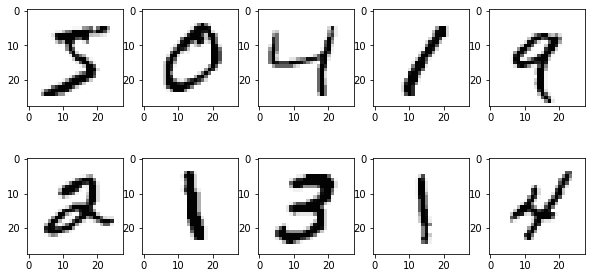

In [21]:
# 원본 데이터 시각화
plt.figure(figsize=(10,5))
for i in range(2*5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_tn0[i].reshape((28,28)),
               cmap='Greys')
plt.show()

In [22]:
# 피처 데이터 스케일 조정
X_tn_re = X_tn0.reshape(60000,28,28,1)
X_tn = X_tn_re/255
print(X_tn.shape)

X_te_re = X_te0.reshape(10000,28,28,1)
X_te = X_te_re/255
print(X_te.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [23]:
# 노이즈 피처 데이터
X_tn_noise = X_tn + np.random.uniform(-1,1,size=X_tn.shape)
X_te_noise = X_te + np.random.uniform(-1,1,size=X_te.shape)
# 노이즈 데이터 스케일링
X_tn_ns = np.clip(X_tn_noise, a_min=0, a_max=1)
X_te_ns = np.clip(X_te_noise, a_min=0, a_max=1)

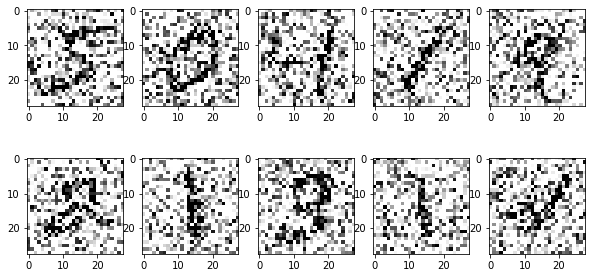

In [24]:
# 노이즈 데이터 시각화
plt.figure(figsize=(10,5))
for i in range(2*5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_tn_ns[i].reshape((28,28))
               ,cmap='Greys')
plt.show()

In [25]:
# 인코더 모형 생성
input_layer1 = Input(shape=(28,28,1))
x1 = Conv2D(20, kernel_size=(5,5),
            padding='same')(input_layer1)
x1 = Activation(activation='relu')(x1)
output_layer1 = MaxPool2D(pool_size=2,
                          padding='same')(x1)
encoder = Model(input_layer1, output_layer1)
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


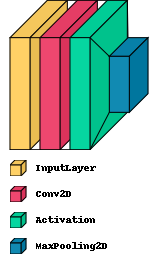

In [26]:
import visualkeras
visualkeras.layered_view(encoder, legend=True)

In [27]:
# 인코더 아웃풋 차원
print(output_layer1.shape) #디코더 모형의 인풋 사이즈로 적용

(None, 14, 14, 20)


In [28]:
# 디코더 모형 생성
input_layer2 = Input(shape=output_layer1.shape[1:4])
x2 = Conv2D(10, kernel_size=(5,5),
            padding='same')(input_layer2)
x2 = Activation(activation='relu')(x2)
x2 = UpSampling2D()(x2) #줄어들었던 차원을 높여줄 수 있음
x2 = Conv2D(1, kernel_size=(5,5),
            padding='same')(x2)
output_layer2 = Activation(activation='relu')(x2)
decoder = Model(input_layer2, output_layer2)
decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 14, 14, 20)]      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 10)        5010      
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 10)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         251       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 1)         0         
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________

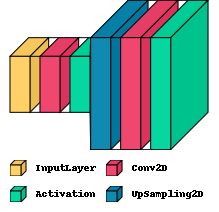

In [29]:
import visualkeras
visualkeras.layered_view(decoder, legend=True)

In [30]:
# 오토 인코더 모형 생성
input_auto = Input(shape=(28,28,1))
output_auto = decoder(encoder(input_auto))
auto_encoder = Model(input_auto, output_auto)
auto_encoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_3 (Model)              (None, 14, 14, 20)        520       
_________________________________________________________________
model_4 (Model)              (None, 28, 28, 1)         5261      
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 모형 컴파일
auto_encoder.compile(loss='mean_squared_error',
                     optimizer='adam',
                     metrics=['mean_squared_error'])

In [32]:
# 학습
hist = auto_encoder.fit(X_tn_ns, X_tn,
                 epochs=1,
                 batch_size=100)

Train on 60000 samples
60000/60000 [==============================] - 39s 658us/sample - loss: 0.0275 - mean_squared_error: 0.0275


In [33]:
X_pred = auto_encoder.predict(X_tn_ns)

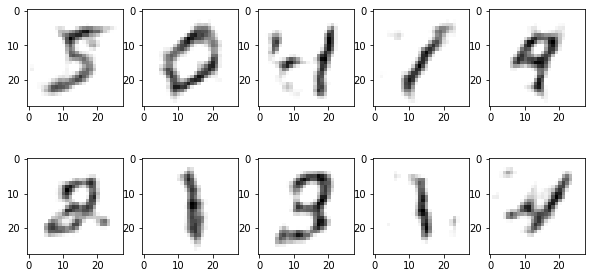

[5 0 4 1 9 2 1 3 1 4]


In [34]:
plt.figure(figsize=(10,5))
for i in range(2*5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_pred[i].reshape((28,28)),
               cmap='Greys')
plt.show()
print(y_tn0[0:10])